In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import nivapy3 as nivapy
import rpy2.rinterface

%load_ext rpy2.ipython

# Generalised Additive Models (GAMs) for the 1000 Lakes dataset

A quick attempt at using a GAM to explore variations in Ca concentration.

## 1. Prepare data using Python

In [ ]:
# Read data
df = pd.read_csv('1000_lakes_lw_am.csv')
df = df.query('(value_am >= 0) and (status == "Authorised")')
df.head()

In [ ]:
# Read station co-ords
stn_df = pd.read_excel('am1000sjoer.xlsx', sheet_name='StationPoint')
stn_df = stn_df[['StationId', 'Latitude', 'Longitude']]
stn_df.columns = ['station_id', 'lat', 'lon']

# Join
df = pd.merge(df, stn_df, how='left', on='station_id')
df.rename({'value_lw':2019,
           'value_am':1995},
          axis=1,
          inplace=True)

df = df[['station_id', 'station_name', 'lat', 'lon', 'parameter', 1995, 2019]]

# Some samples seem to have been analysed and approved more than once?
df = df.groupby(by=['station_id', 'station_name', 'lat', 'lon', 'parameter']).mean()
df.reset_index(inplace=True)

In [ ]:
# Restructure
df = pd.melt(df, 
             id_vars=['station_id', 'station_name', 'lat', 'lon', 'parameter'],
             var_name='year')

df.set_index(['station_id', 'station_name', 'lat', 'lon', 'parameter', 'year'],
             inplace=True)

df = df.unstack('parameter')
df.reset_index(inplace=True)
df.columns = list(df.columns.get_level_values(0)[:5]) + list(df.columns.get_level_values(1)[5:])
df.columns = [i.replace(" ", "") for i in df.columns]

# WGS to UTM
df = nivapy.spatial.wgs84_dd_to_utm(df, lat='lat', lon='lon', utm_zone=33)

# Save
df.to_csv('gam_data.csv', index=False)

df

In [ ]:
# Summary for Ca in each time period
df.groupby(by='year').describe().T.loc['Kalsium']

## 2. Build GAM using R

In [2]:
%%R

# Load packages
library(mgcv)
library(ggplot2)
library(dplyr)
library(viridis)

# Read dataset
df = read.csv('gam_data.csv')
head(df)

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:nlme’:

    collapse


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: viridisLite



  station_id station_name      lat      lon year Alkalitet Aluminium
1      26070    Langtjern 59.80864 11.85027 1995     0.042        NA
2      26070    Langtjern 59.80864 11.85027 2019     0.054        NA
3      26071    Hokksjøen 59.00442 11.56359 1995     0.032        NA
4      26071    Hokksjøen 59.00442 11.56359 2019     0.030        NA
5      26072   Sætertjern 60.06022 12.44671 1995     0.049        NA
6      26072   Sætertjern 60.06022 12.44671 2019     0.057        NA
  Aluminium.ikkelabil Aluminium.reaktivt Ammonium Arsen Bly    Ca.Mg Fluorid
1                 111                131       NA    NA  NA 3.459459      40
2                 130                150       NA    NA  NA 3.314286      21
3                 141                202       NA    NA  NA 1.567164      40
4                 220                280       NA    NA  NA 1.448276      31
5                 130                182       NA    NA  NA 2.648148     180
6                 130                200       NA    NA


Family: gaussian 
Link function: identity 

Formula:
Totalorganiskkarbon.TOC. ~ te(utm_east, utm_north) + year

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -68.186672   9.021024  -7.559 6.72e-14 ***
year          0.035597   0.004495   7.920 4.33e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                         edf Ref.df     F p-value    
te(utm_east,utm_north) 22.96   23.3 120.8  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.63   Deviance explained = 63.6%
GCV = 4.9494  Scale est. = 4.8757    n = 1676


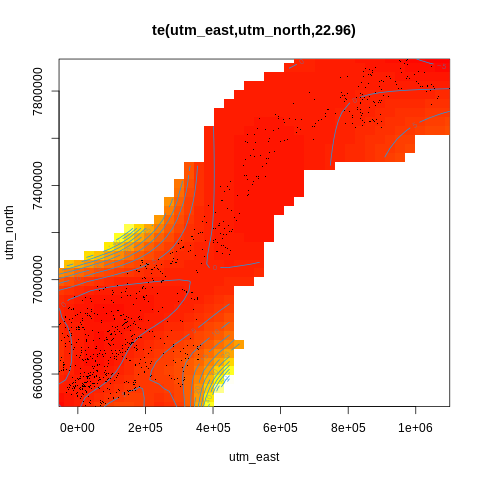

In [10]:
%%R

# Explore models
model = gam(Totalorganiskkarbon.TOC. ~ te(utm_east, utm_north) + year,
            data=df)

plot(model, scheme = 2)
summary(model)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 21 iterations.
The RMS GCV score gradient at convergence was 2.698459e-06 .
The Hessian was positive definite.
Model rank =  26 / 26 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                       k' edf k-index p-value    
te(utm_east,utm_north) 24  23    0.69  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


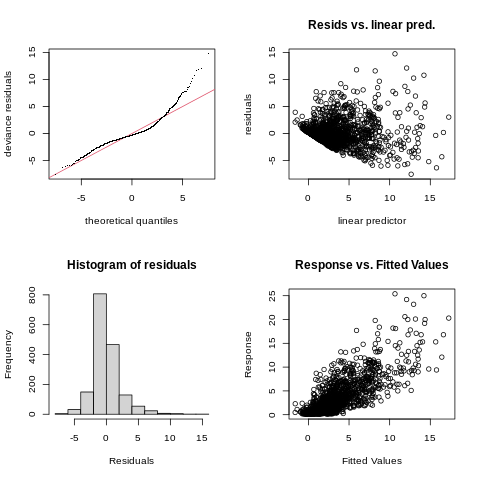

In [11]:
%%R

gam.check(model)